In [80]:
# imports: 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json

# importing module
import sys
 
# appending a path
sys.path.append('../')
from src.lib.opts import opts
from src.lib.utils.pnp.cuboid_pnp_shell import pnp_shell

## Finding the Pointorder of the Objectron dataset:

### Start with loading the Objectron image: 


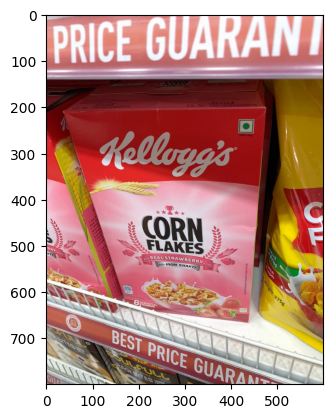

In [81]:
img= plt.imread("../data/cereal_example.png")
plt.imshow(img)

### Now load the jsonfile for the example: 


In [82]:
with open("../data/example_json.json", "r") as f:
    data=json.load(f)
o_points=data["objects"][0]["projected_cuboid"] # here are the points, the objectron json has way more contend
print(o_points)


[[298, 427], [212, 532], [170, 643], [115, 143], [14, 203], [453, 548], [457, 674], [480, 120], [499, 182]]


### Now plot the points on the image

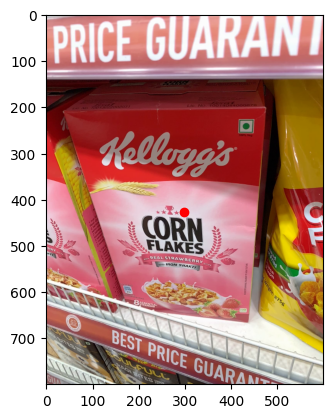

In [83]:
# first point is the center

plt.imshow(img)
plt.plot(o_points[0][0], o_points[0][1], "ro")
plt.show()

- the first point is the center
- then the left side of the box
- then the right side of the box

Always starting from the bottom to the top (backside first)

/tmp/ipykernel_83770/1255917934.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(p[0], p[1], cmap='b')


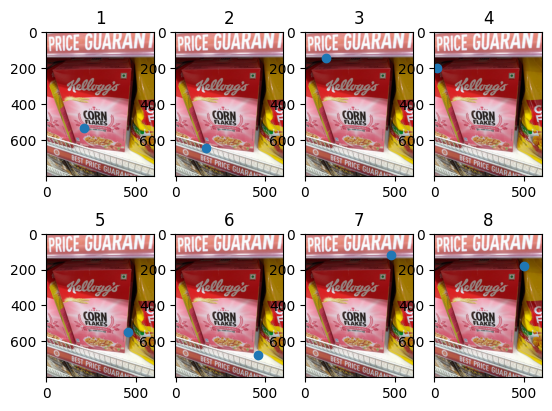

In [84]:
for i, p in enumerate(o_points[1:]):
     plt.subplot(2,4,i+1)
     plt.imshow(img)
     plt.scatter(p[0], p[1], cmap='b')
     plt.title(f"{i+1}")
plt.show()
    

### This order is very importend for the PNP algorithm. If the order is wrong the PNP cannot be solved correctly. 

### Explanation of PNP:

The PnP solver is designed to determine the 3D box based on its 8 vertices. It does this by matching the pixel coordinates of the 8 vertices in the image to the real 3D model of the box. If the dimensions of the box are known, a 3D representation can be created that only requires the position and rotation to match the image (6 degrees of freedom).

The algorithm iteratively searches for the position and rotation by using the 2D points one by one and mapping them to the correct 3D point. When only one point is used, the position is fixed, but the box can still rotate (3 degrees of freedom left). Each additional point decreases the degrees of freedom by one, so using a total of 4 points can solve the problem.

We use 8 points because each point is an estimation with an error margin, and using multiple points helps to find the best combination of all the points for accurate results.

What if the point order is wrong? If the order of the points is incorrect, the PnP algorithm may match a 2D point to the wrong 3D point. This can result in wrong or unsolvable equations, leading to inaccurate results. Therefore, ensuring the correct order of points is crucial for obtaining accurate solutions with the PnP algorithm.

### check the pointorder of the Ford Data: 

#### Load the ford image and the data: 

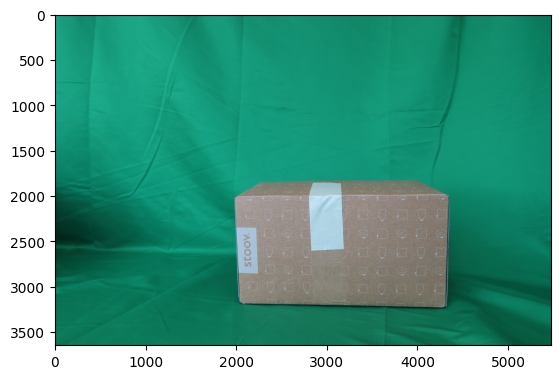

In [85]:
# load an image based on the numeber: 
name="0623"
img=plt.imread("../data/green_boxes/IMG_"+name+".JPG")
plt.imshow(img)

In [86]:
# Load the data: 
# load the json files:
with open("../data/green_boxes/train.json", 'r') as f:
    train= json.load(f)
    
with open("../data/green_boxes/val.json", 'r') as f:
    val= json.load(f)
    
data=train+val
print(len(data))


443


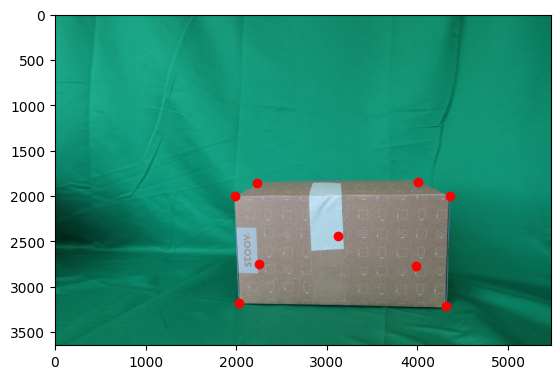

In [87]:

# find the image annotation in the annotationfile: 
points=[]
size=[]
for dict in data:
    if name in dict["image_name"]:
        points=dict["points"]
        size=dict["size"]
        break
if points==[]:
    print("no annotation found for this image")
    
    
else:
    h, w, c=img.shape 
    plt.imshow(img)
    for p in points:
        plt.plot(p[0],h-p[1], 'ro')  # green background points are stored inverted
    plt.show()

Check the order of the points

/tmp/ipykernel_83770/2724687831.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(p[0], h-p[1], cmap='b')


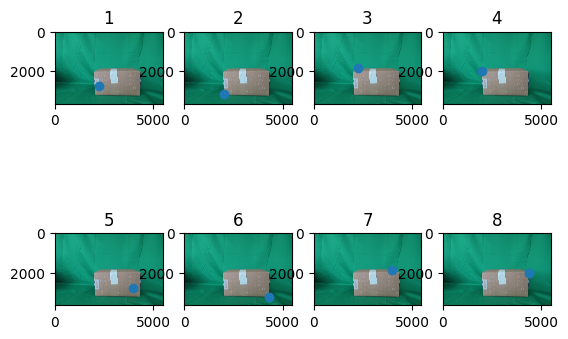

In [88]:
for i, p in enumerate(points[1:]):
     plt.subplot(2,4,i+1)
     plt.imshow(img)
     plt.scatter(p[0], h-p[1], cmap='b')
     plt.title(f"{i+1}")
plt.show() 

### Test the PNP algotithm on the Ford data to confirm that it works: 


In [89]:
# init
opt = opts()
opt.nms = True
opt.obj_scale = True
opt.c="cereal_box"
camera_ford=np.array([[3648, 0, 2736], [0, 3648, 1824], [0, 0, 1]], dtype=np.float32)
meta={"width": 5472,"height": 3648, "camera_matrix":camera_ford }

for i, p in enumerate(points):
    points[i]=[p[0], h-p[1]]

In [90]:
bbox= {'kps': points, "obj_scale": size}
projected_points, point_3d_cam, scale, points_ori, bbox=pnp_shell(opt, meta, bbox, points, size, OPENCV_RETURN=False)
print(bbox["projected_cuboid"])

[[2475.13169469 2656.79462755]
 [2130.40890635 3104.04147109]
 [2399.91988732 1847.87328144]
 [2014.43469962 2066.34099352]
 [4121.43384626 2695.51753803]
 [4286.00595308 3226.23522826]
 [4108.15015209 1789.56172925]
 [4277.59245433 2023.21725178]]


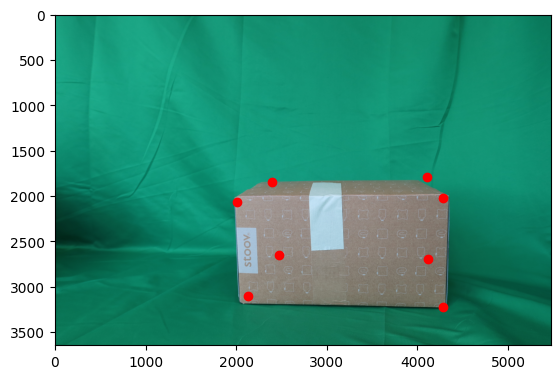

In [91]:
plt.imshow(img)
for p in bbox["projected_cuboid"]:
    plt.plot(p[0], p[1], "ro")
plt.show()